# Análisis CIC-IDS-2018

## Introducción

En el siguiente *Notebook* se realiza un pequeño preprocesado del *dataset* CIC-IDS-2018 tanto para los modelos basados en la detección de anomalías como en la detección de firmas.

## Librerías

In [1]:
import gc
import math
import pandas as pd
from glob import glob
from os import getcwd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB 
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

pd.set_option("display.max_columns", 80)

## Carga del conjunto

In [2]:
df_from_each_file = []
# This will help pandas identify N/a values
na_val = ['N/a', 'na', 'Na', 'NA', 'NAN', 'Nan', 'NaN', np.nan]

for file in glob(getcwd() + "/../../Processed Traffic Data for ML Algorithms/*.csv"):
    print(f'Appending {file}')
    read_df = pd.read_csv(file, sep=',', low_memory=False, na_values=na_val)
    if 'Unnamed: 0' in list(read_df.columns):
        read_df.drop(['Unnamed: 0'], axis=1, inplace=True)
    df_from_each_file.append(read_df)

df = pd.concat(df_from_each_file, ignore_index=True)
del(read_df, df_from_each_file)

Appending /home/jovyan/My-Notebooks/Data Preprocess/../../Processed Traffic Data for ML Algorithms/New-Friday-16-02-2018_TrafficForML_CICFlowMeter.csv
Appending /home/jovyan/My-Notebooks/Data Preprocess/../../Processed Traffic Data for ML Algorithms/New-Thursday-01-03-2018_TrafficForML_CICFlowMeter.csv
Appending /home/jovyan/My-Notebooks/Data Preprocess/../../Processed Traffic Data for ML Algorithms/Friday-02-03-2018_TrafficForML_CICFlowMeter.csv
Appending /home/jovyan/My-Notebooks/Data Preprocess/../../Processed Traffic Data for ML Algorithms/Thursday-22-02-2018_TrafficForML_CICFlowMeter.csv
Appending /home/jovyan/My-Notebooks/Data Preprocess/../../Processed Traffic Data for ML Algorithms/Wednesday-21-02-2018_TrafficForML_CICFlowMeter.csv
Appending /home/jovyan/My-Notebooks/Data Preprocess/../../Processed Traffic Data for ML Algorithms/Friday-23-02-2018_TrafficForML_CICFlowMeter.csv
Appending /home/jovyan/My-Notebooks/Data Preprocess/../../Processed Traffic Data for ML Algorithms/Wedn

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16232943 entries, 0 to 16232942
Data columns (total 80 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Dst Port           int64  
 1   Protocol           int64  
 2   Timestamp          object 
 3   Flow Duration      int64  
 4   Tot Fwd Pkts       int64  
 5   Tot Bwd Pkts       int64  
 6   TotLen Fwd Pkts    float64
 7   TotLen Bwd Pkts    float64
 8   Fwd Pkt Len Max    float64
 9   Fwd Pkt Len Min    float64
 10  Fwd Pkt Len Mean   float64
 11  Fwd Pkt Len Std    float64
 12  Bwd Pkt Len Max    float64
 13  Bwd Pkt Len Min    float64
 14  Bwd Pkt Len Mean   float64
 15  Bwd Pkt Len Std    float64
 16  Flow Byts/s        float64
 17  Flow Pkts/s        float64
 18  Flow IAT Mean      float64
 19  Flow IAT Std       float64
 20  Flow IAT Max       float64
 21  Flow IAT Min       float64
 22  Fwd IAT Tot        float64
 23  Fwd IAT Mean       float64
 24  Fwd IAT Std        float64
 25  Fwd IAT Max     

In [4]:
df.describe()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.617322e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,16232943.0,1.623294e+07,16232943.0,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,16232943.0,16232943.0,16232943.0,16232943.0,16232943.0,16232943.0,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07
mean,9.164073e+03,8.754113e+00,1.181380e+07,2.353319e+01,6.312706e+00,9.730373e+02,4.730931e+03,2.007620e+02,1.107600e+01,5.031274e+01,7.084147e+01,3.501495e+02,2.647805e+01,1.130759e+02,1.315657e+02,inf,inf,3.335397e+06,1.275574e+06,6.602697e+06,2.321854e+06,1.152313e+07,3.661300e+06,1.402965e+06,6.409625e+06,2.409649e+06,7.597374e+06,8.241998e+05,8.511741e+05,2.612947e+06,2.912304e+05,4.389543e-02,0.0,1.638027e-04,0.0,2.575408e+02,1.330935e+02,3.667251e+04,1.531596e+04,1.094256e+01,3.893461e+02,7.762634e+01,1.214681e+02,4.117054e+04,4.795434e-03,4.389543e-02,1.873980e-01,3.920842e-01,3.316020e-01,4.171302e-02,1.638027e-04,1.873986e-01,4.964363e-01,8.954040e+01,5.031274e+01,1.130759e+02,0.0,0.0,0.0,0.0,0.0,0.0,2.353319e+01,9.730373e+02,6.312706e+00,4.730909e+03,8.787202e+03,8.689131e+03,1.989528e+01,1.799267e+01,1.728776e+05,8.644097e+04,2.623920e+05,1.154657e+05,5.016958e+06,2.866491e+05,5.428144e+06,4.685631e+06
std,1.892224e+04,4.920117e+00,4.940124e+08,1.521137e+03,1.640256e+02,6.216906e+04,2.344659e+05,3.035091e+02,2.422938e+01,6.050561e+01,1.164407e+02,4.974234e+02,5.097873e+01,1.641056e+02,2.042592e+02,NaN,NaN,2.229483e+08,3.381128e+08,6.595104e+08,7.476211e+08,4.940071e+08,2.229602e+08,3.381193e+08,6.595084e+08,7.476241e+08,2.586288e+07,4.340497e+06,3.376930e+06,1.024426e+07,3.825444e+06,2.048624e-01,0.0,1.279750e-02,0.0,1.226352e+04,3.265496e+03,2.133241e+05,9.241990e+04,2.261941e+01,5.141581e+02,1.037008e+02,1.625302e+02,2.129773e+05,6.908283e-02,2.048624e-01,3.902307e-01,4.882153e-01,4.707888e-01,1.999326e-01,1.279750e-02,3.902312e-01,9.967273e-01,1.082233e+02,6.050561e+01,1.641056e+02,0.0,0.0,0.0,0.0,0.0,0.0,1.521137e+03,6.216906e+04,1.640256e+02,2.344556e+05,1.623560e+04,2.061931e+04,1.519917e+03,7.693845e+00,2.505927e+06,1.514575e+06,3.319230e+06,2.114145e+06,2.633178e+08,1.691887e+08,6.253704e+08,6.365202e+07
min,0.000000e+00,0.000000e+00,-9.190110e+11,1.000000e+00,0.000000e+0

### Distribución del tráfico

A continuación se muestran una serie de figuras sobre la distribución del tráfico y los tipos de ataque que contiene el dataset.

Text(0.5, 1.0, 'CSE-CIC-IDS-2028 distribution of traffic type')

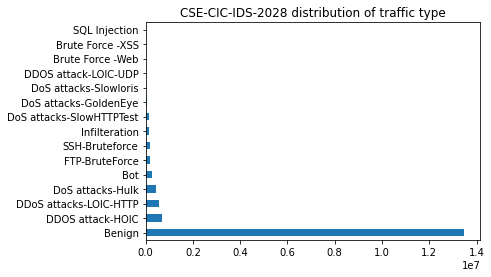

In [5]:
df['Label'].value_counts().plot(kind='barh')
plt.title('CSE-CIC-IDS-2028 distribution of traffic type')

In [6]:
benign_count = df["Label"].value_counts()[['Benign']].sum()
malicious_count = df[df["Label"]!='Benign'].value_counts().sum()
total = benign_count + malicious_count

print('Benign Traffic = ' + str(benign_count/total*100) + '%.')
print('Malicious Traffic = ' + str(malicious_count/total*100) + '%.')
del(benign_count, malicious_count, total)

Benign Traffic = 83.07433314693313%.
Malicious Traffic = 16.925666853066875%.


In [7]:
benign_count = df["Label"].value_counts()[['Benign']].sum()
malicious_count = df[df["Label"]!='Benign'].value_counts().sum()
total = benign_count + malicious_count

print('Benign Traffic = ' + str(benign_count/total*100) + '%.')
print('Malicious Traffic = ' + str(malicious_count/total*100) + '%.')
del(benign_count, malicious_count, total)

Benign Traffic = 83.07433314693313%.
Malicious Traffic = 16.925666853066875%.


## Data Prepraration

### Data Cleaning

Para preprocesar los datos para un mejor análisis, primero realizamos una limpieza de datos. Esto conlleva eliminar atributos nulos, características constantes (no varían), valores infinitos, duplicados o corruptos. Para esta prueba, se eliminó el atributo 'Timestamp', ya que al ser una toma de contacto no se consideró realmente necesario para analizar el conjunto entero.

Al eliminar duplicados, se encontró que el número de ataques de 'DoS attacks-SlowHTTPTest' se reducía de 40% a menos del 1% sobre el total de tráfico del dataset. Por lo tanto, se ha omitido el duplicado de atributos.

In [8]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
df['Timestamp'].dtypes

dtype('<M8[ns]')

In [9]:
df.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,2018-02-16 08:27:23,112640768,3,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.026633,5.630000e+07,1.385929e+02,56300000.0,56300000.0,113000000.0,5.630000e+07,1.385929e+02,56300000.0,56300000.0,0.0,0.0000,0.000,0.0,0.0,0,0,0,0,0,0,0.026633,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0.0,0.000000,0.000000,0.000000,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0.0,0.0,0.0,0.0,56300000.0,138.592929,56300000.0,56300000.0,Benign
1,0,0,2018-02-16 08:30:12,112641773,3,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.026633,5.630000e+07,2.637508e+02,56300000.0,56300000.0,113000000.0,5.630000e+07,2.637508e+02,56300000.0,56300000.0,0.0,0.0000,0.000,0.0,0.0,0,0,0,0,0,0,0.026633,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0.0,0.000000,0.000000,0.000000,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0.0,0.0,0.0,0.0,56300000.0,263.750829,56300000.0,56300000.0,Benign
2,35605,6,2018-02-16 08:26:55,20784143,23,44,2416.0,1344.0,240.0,64.0,105.043478,54.542292,64.0,0.0,30.545455,32.336497,180.907146,3.223611,3.149113e+05,1.145954e+06,9058214.0,66.0,20700000.0,9.404843e+05,1.898330e+06,9144734.0,66.0,20700000.0,482352.2093,1396411.114,9058214.0,41601.0,1,0,0,0,460,880,1.106613,2.116999,0.0,240.0,56.235294,53.851681,2900.003512,0,1,0,0,1,0,0,0,1.0,57.074627,105.043478,30.545455,0,0,0,0,0,0,23,2416,44,1344,263,255,22,20,2624734.0,0.0,2624734.0,2624734.0,9058214.0,0.000000,9058214.0,9058214.0,Benign
3,0,0,2018-02-16 08:33:01,112640836,3,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.026633,5.630000e+07,8.202439e+01,56300000.0,56300000.0,113000000.0,5.630000e+07,8.202439e+01,56300000.0,56300000.0,0.0,0.0000,0.000,0.0,0.0,0,0,0,0,0,0,0.026633,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0.0,0.000000,0.000000,0.000000,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0.0,0.0,0.0,0.0,56300000.0,82.024387,56300000.0,56300000.0,Benign
4,23,6,2018-02-16 08:27:59,20,1,1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,100000.000000,2.000000e+01,0.000000e+00,20.0,20.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0000,0.000,0.0,0.0,0,0,0,0,20,20,50000.000000,50000.000000,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,1,0,0,0,0,1.0,0.000000,0.000000,0.000000,0,0,0,0,0,0,1,0,1,0,58856,0,0,20,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign


### Missing Values

In [10]:
missed_val = df.isnull().sum()
missed_val_rate = 100 * df.isnull().sum() / len(df)
table = pd.concat([missed_val, missed_val_rate], axis=1)

table = table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
table = table[table.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)

display(table)
del(missed_val, missed_val_rate, table)

,Missing Values,% of Total Values
Flow Byts/s,59721,0.4


,Count,% of total Values
Benign,58877,0.436621
Infilteration,838,0.517495
FTP-BruteForce,6,0.003103


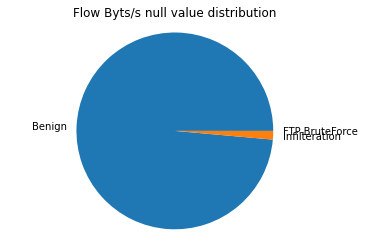

In [11]:
null_df = df[df['Flow Byts/s'].isna()]
null_df['Label'].value_counts().plot(kind='pie')
plt.title('Flow Byts/s null value distribution')
plt.axis('equal')
plt.ylabel('')

missed_val = null_df['Label'].value_counts()
missed_val_rate = null_df['Label'].value_counts() / df['Label'].value_counts()[['Benign', 'Infilteration', 'FTP-BruteForce']] * 100
table = pd.concat([missed_val, missed_val_rate], axis=1)
table.columns = ['Count', '% of total Values']

display(table)
del(missed_val, missed_val_rate, table)

del(null_df)

In [12]:
# Podemos dropear valores nulos con seguridad
df.dropna(0, inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  


In [13]:
gc.collect()

2380

### Características Constantes

In [14]:
value_count = df['Label'].value_counts()
value_rate = df['Label'].value_counts() / len(df['Label']) * 100
table = pd.concat([value_count, value_rate], axis=1)
table.columns = ['Count', '% of total Values']

display(table)

drop_cols = []
for col in df.columns:
    if len(df[col].unique())==1:
        drop_cols.append(col)
if drop_cols != []:
    df.drop(drop_cols, 1, inplace=True)
    
value_count = df['Label'].value_counts()
value_rate = df['Label'].value_counts() / len(df['Label']) * 100
table = pd.concat([value_count, value_rate], axis=1)
table.columns = ['Count', '% of total Values']

display(table)

,Count,% of total Values
Benign,13484708,83.070014
DDOS attack-HOIC,686012,4.226048
DDoS attacks-LOIC-HTTP,576191,3.549517
DoS attacks-Hulk,461912,2.845522
Bot,286191,1.763026
FTP-BruteForce,193360,1.191158
SSH-Bruteforce,187589,1.155607
Infilteration,161934,0.997564
DoS attacks-SlowHTTPTest,139890,0.861766
DoS attacks-GoldenEye,41508,0.255702


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  del sys.path[0]


,Count,% of total Values
Benign,13484708,83.070014
DDOS attack-HOIC,686012,4.226048
DDoS attacks-LOIC-HTTP,576191,3.549517
DoS attacks-Hulk,461912,2.845522
Bot,286191,1.763026
FTP-BruteForce,193360,1.191158
SSH-Bruteforce,187589,1.155607
Infilteration,161934,0.997564
DoS attacks-SlowHTTPTest,139890,0.861766
DoS attacks-GoldenEye,41508,0.255702


In [15]:
del(drop_cols, value_count, value_rate, table)
gc.collect()

20

### Infinite values

In [16]:
with pd.option_context('mode.use_inf_as_na', True):
    missed_val = df.isnull().sum()
    missed_val_rate = 100 * df.isnull().sum() / len(df)
    table = pd.concat([missed_val, missed_val_rate], axis=1)

    table = table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    table = table[table.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)

    display(table)
    del(missed_val, missed_val_rate, table)

,Missing Values,% of Total Values
Flow Pkts/s,95760,0.6


,Count,% of total Values
Benign,94459,0.700490
Infilteration,1295,0.799709
FTP-BruteForce,6,0.003103


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only


,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07
mean,9.164073e+03,8.754113e+00,1.181380e+07,2.353319e+01,6.312706e+00,9.730373e+02,4.730931e+03,2.007620e+02,1.107600e+01,5.031274e+01,7.084147e+01,3.501495e+02,2.647805e+01,1.130759e+02,1.315657e+02,3.335397e+06,1.275574e+06,6.602697e+06,2.321854e+06,1.152313e+07,3.661300e+06,1.402965e+06,6.409625e+06,2.409649e+06,7.597374e+06,8.241998e+05,8.511741e+05,2.612947e+06,2.912304e+05,4.389543e-02,1.638027e-04,2.575408e+02,1.330935e+02,3.667251e+04,1.531596e+04,1.094256e+01,3.893461e+02,7.762634e+01,1.214681e+02,4.117054e+04,4.795434e-03,4.389543e-02,1.873980e-01,3.920842e-01,3.316020e-01,4.171302e-02,1.638027e-04,1.873986e-01,4.964363e-01,8.954040e+01,5.031274e+01,1.130759e+02,2.353319e+01,9.730373e+02,6.312706e+00,4.730909e+03,8.787202e+03,8.689131e+03,1.989528e+01,1.799267e+01,1.728776e+05,8.644097e+04,2.623920e+05,1.154657e+05,5.016958e+06,2.866491e+05,5.428144e+06,4.685631e+06
std,1.892224e+04,4.920117e+00,4.940124e+08,1.521137e+03,1.640256e+02,6.216906e+04,2.344659e+05,3.035091e+02,2.422938e+01,6.050561e+01,1.164407e+02,4.974234e+02,5.097873e+01,1.641056e+02,2.042592e+02,2.229483e+08,3.381128e+08,6.595104e+08,7.476211e+08,4.940071e+08,2.229602e+08,3.381193e+08,6.595084e+08,7.476241e+08,2.586288e+07,4.340497e+06,3.376930e+06,1.024426e+07,3.825444e+06,2.048624e-01,1.279750e-02,1.226352e+04,3.265496e+03,2.133241e+05,9.241990e+04,2.261941e+01,5.141581e+02,1.037008e+02,1.625302e+02,2.129773e+05,6.908283e-02,2.048624e-01,3.902307e-01,4.882153e-01,4.707888e-01,1.999326e-01,1.279750e-02,3.902312e-01,9.967273e-01,1.082233e+02,6.050561e+01,1.641056e+02,1.521137e+03,6.216906e+04,1.640256e+02,2.344556e+05,1.623560e+04,2.061931e+04,1.519917e+03,7.693845e+00,2.505927e+06,1.514575e+06,3.319230e+06,2.114145e+06,2.633178e+08,1.691887e+08,6.253704e+08,6.365202e+07
min,0.000000e+00,0.000000e+00,-9.190110e+11,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.282200e+11,0.000000e+00,-8.282200e+11,-9.474050e+11,-9.190110e+11,-8.282200e+11,0.000000e+00,-8.282200e+11,-9.474050e+11,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000

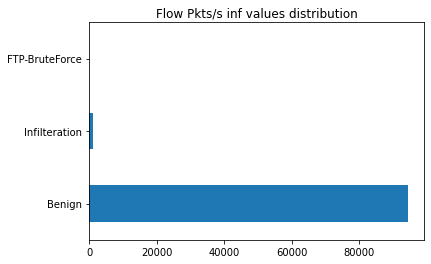

In [17]:
with pd.option_context('mode.use_inf_as_na', True):

    null_df = df[df['Flow Pkts/s'].isna()]
    null_df['Label'].value_counts().plot(kind='barh')
    plt.title('Flow Pkts/s inf values distribution')

    missed_val = null_df['Label'].value_counts()
    missed_val_rate = null_df['Label'].value_counts() / df['Label'].value_counts()[['Benign', 'Infilteration', 'FTP-BruteForce']] * 100
    table = pd.concat([missed_val, missed_val_rate], axis=1)
    table.columns = ['Count', '% of total Values']

    display(table)
    del(missed_val, missed_val_rate, table)
    del(null_df)
    
    # Podemos dropear valores infinitos con seguridad
    df.dropna(0, inplace=True)

df.describe()

### Collinearity 

Para realizar una selección de atributos, estudiaremos su correlación. En modelos de aprendizaje supervisado, las características correlacionadas en general no los mejoran, pero sí pueden afectar a modelos específicos de diferentes maneras. Hay tres razones principales para eliminar las atributos correlacionadas:

* Reducción de la dimensionalidad.
* Disminuir el sesgo perjudicial.
* Interpretabilidad del modelo.

En términos generales, es preferible un modelo más simple, o lo que es lo mismo, un modelo con menos características. Por ello, se eliminarán las características con una **correlación superior al 90%**.

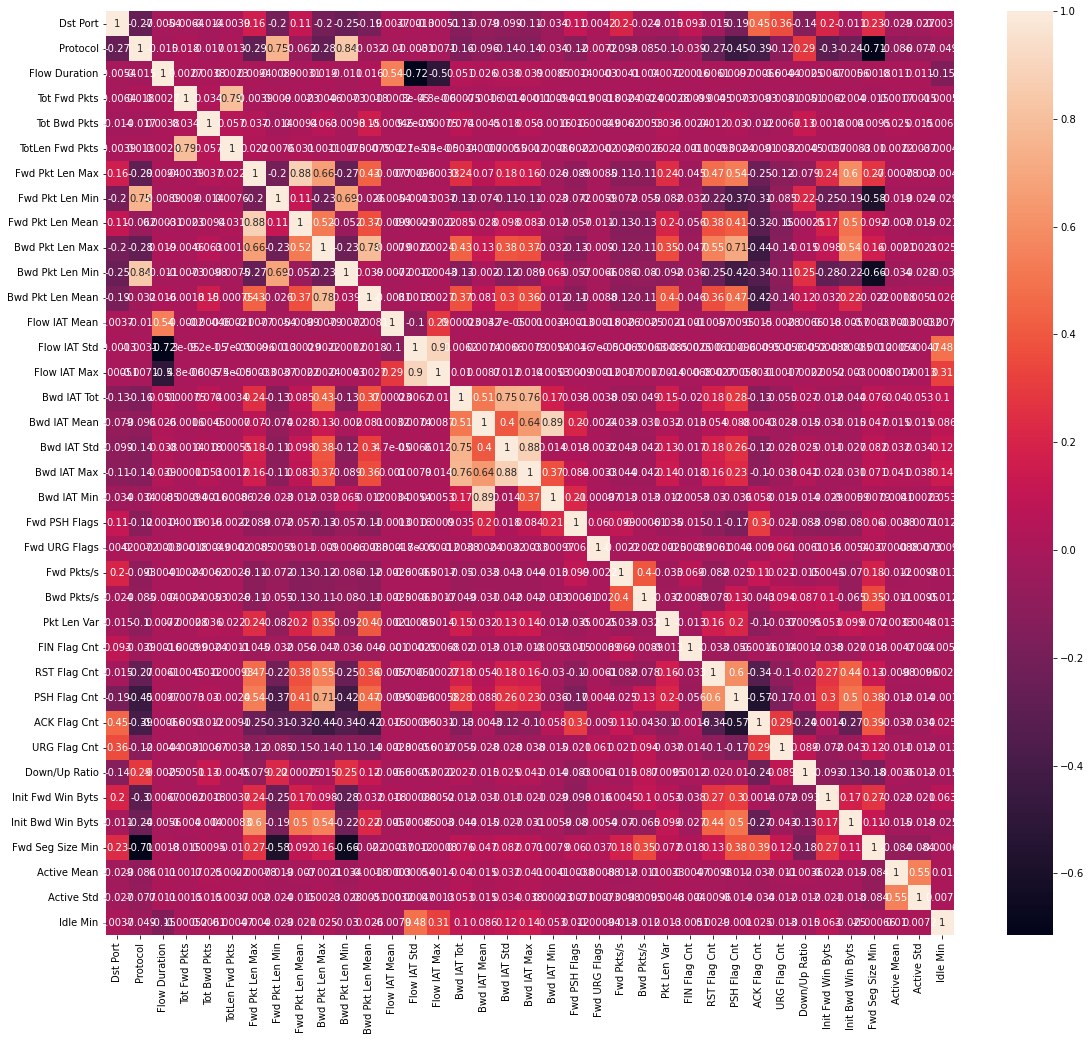

In [18]:
# Se eliminan características altamente correlacionadas
col_corr = set()
corr_matrix = df.corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i,j])>0.90:
            colname = corr_matrix.columns[i]
            col_corr.add(colname)
df.drop(col_corr, axis=1, inplace=True)
del(corr_matrix, col_corr)

corr = df.corr()
plt.figure(figsize=(19,17))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)
plt.show()
del(corr)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16232943 entries, 0 to 16232942
Data columns (total 39 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Dst Port           int64         
 1   Protocol           int64         
 2   Timestamp          datetime64[ns]
 3   Flow Duration      int64         
 4   Tot Fwd Pkts       int64         
 5   Tot Bwd Pkts       int64         
 6   TotLen Fwd Pkts    float64       
 7   Fwd Pkt Len Max    float64       
 8   Fwd Pkt Len Min    float64       
 9   Fwd Pkt Len Mean   float64       
 10  Bwd Pkt Len Max    float64       
 11  Bwd Pkt Len Min    float64       
 12  Bwd Pkt Len Mean   float64       
 13  Flow IAT Mean      float64       
 14  Flow IAT Std       float64       
 15  Flow IAT Max       float64       
 16  Bwd IAT Tot        float64       
 17  Bwd IAT Mean       float64       
 18  Bwd IAT Std        float64       
 19  Bwd IAT Max        float64       
 20  Bwd IAT Min        flo

In [20]:
value_count = df['Label'].value_counts()
value_rate = df['Label'].value_counts() / len(df['Label']) * 100
table = pd.concat([value_count, value_rate], axis=1)
table.columns = ['Count', '% of total Values']

display(table)

,Count,% of total Values
Benign,13484708,83.070014
DDOS attack-HOIC,686012,4.226048
DDoS attacks-LOIC-HTTP,576191,3.549517
DoS attacks-Hulk,461912,2.845522
Bot,286191,1.763026
FTP-BruteForce,193360,1.191158
SSH-Bruteforce,187589,1.155607
Infilteration,161934,0.997564
DoS attacks-SlowHTTPTest,139890,0.861766
DoS attacks-GoldenEye,41508,0.255702


In [21]:
del(value_count, value_rate, table)
gc.collect()

92381

### Data transformation

La columna 'Protocol' del dataset indica el número de protocolo que está utilizando cada flujo, debemos considerarla por lo tanto, una variable categórica. Analizando un poco más esta característica vemos que puede tomar tres valores. A partir de esta, se construirán dos atributos, que indican la pertenencia al segundo y tercer protocolo.

Text(0.5, 1.0, 'Distribution of Protocol values')

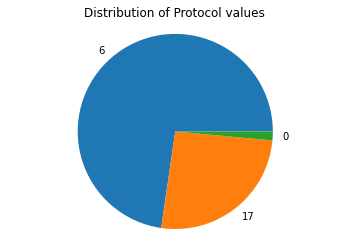

In [22]:
df['Protocol'].value_counts().plot(kind='pie')
plt.axis('equal')
plt.ylabel('')
plt.title('Distribution of Protocol values')

In [23]:
# Categorizamos los valores del protocolo
df = pd.get_dummies(df, columns=['Protocol'], drop_first=True)
df.insert(len(df.columns)-1, 'Label', df.pop('Label'))
df

,Dst Port,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Var,FIN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,Down/Up Ratio,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Active Mean,Active Std,Idle Min,Protocol_6,Protocol_17,Label
0,0,2018-02-16 08:27:23,112640768,3,0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,5.630000e+07,1.385929e+02,56300000.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,0,0.026633,0.000000,0.000000,0,0,0,0,0,0.0,-1,-1,0,0.0,0.000000,56300000.0,0,0,Benign
1,0,2018-02-16 08:30:12,112641773,3,0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,5.630000e+07,2.637508e+02,56300000.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,0,0.026633,0.000000,0.000000,0,0,0,0,0,0.0,-1,-1,0,0.0,0.000000,56300000.0,0,0,Benign
2,35605,2018-02-16 08:26:55,20784143,23,44,2416.0,240.0,64.0,105.043478,64.0,0.0,30.545455,3.149113e+05,1.145954e+06,9058214.0,20700000.0,4.823522e+05,1.396411e+06,9058214.0,41601.0,1,0,1.106613,2.116999,2900.003512,0,0,0,1,0,1.0,263,255,20,2624734.0,0.000000,9058214.0,1,0,Benign
3,0,2018-02-16 08:33:01,112640836,3,0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,5.630000e+07,8.202439e+01,56300000.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,0,0.026633,0.000000,0.000000,0,0,0,0,0,0.0,-1,-1,0,0.0,0.000000,56300000.0,0,0,Benign
4,23,2018-02-16 08:27:59,20,1,1,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,2.000000e+01,0.000000e+00,20.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,0,50000.000000,50000.000000,0.000000,0,0,1,0,0,1.0,58856,0,20,0.0,0.000000,0.0,1,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16232938,50111,2018-02-15 09:04:42,22,3,0,31.0,31.0,0.0,10.333333,0.0,0.0,0.000000,1.100000e+01,1.555635e+01,22.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,0,136363.636364,0.000000,240.250000,0,0,0,1,0,0.0,64,-1,20,0.0,0.000000,0.0,1,0,Benign
16232939,443,2018-02-15 09:03:55,54682783,5,1,123.0,46.0,0.0,24.600000,46.0,46.0,46.000000,1.093656e+07,2.436610e+07,54523813.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1,0,0.091436,0.018287,470.238095,0,0,0,1,0,0.0,256,180,20,158783.0,0.000000,54523813.0,1,0,Benign
16232940,443,2018-02-15 09:03:56,53682093,5,1,123.0,46.0,0.0,24.600000,46.0,46.0,46.000000,1.073642e+07,2.386193e+07,53421756.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1,0,0.093141,0.018628,470.238095,0,0,0,1,0,0.0,254,180,20,259719.0,0.000000,53421756.0,1,0,Benign
16232941,443,2018-02-15 09:03:55,54683364,5,1,123.0,46.0,0.0,24.600000,46.0,46.0,46.000000,1.093667e+07,2.436586e+07,54523593.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1,0,0.091435,0.018287,470.238095,0,0,0,1,0,0.0,254,180,20,158870.0,0.000000,54523593.0,1,0,Benign


### Label Transformation

A continuación, se realizará la transformación de las etiquetas, ya que el objetivo de esta toma de contacto es el análisis para distinguir entre tráfico normal y maligno. Por lo tanto, se transformarán las etiquietas para relaizar una clasificación binaria:

* Normal: 0.
* Maligno: 1.

Text(0.5, 1.0, 'CSE-CIC-IDS-2028 distribution of traffic type')

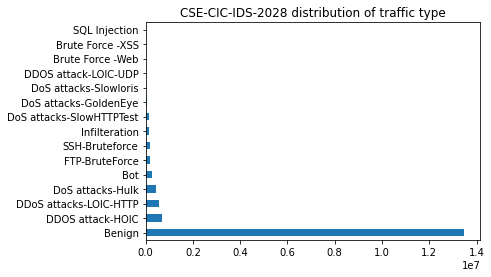

In [24]:
df['Label'].value_counts().plot(kind='barh')
plt.title('CSE-CIC-IDS-2028 distribution of traffic type')

In [25]:
benign_count = df["Label"].value_counts()[['Benign']].sum()
malicious_count = df[df["Label"]!='Benign'].value_counts().sum()
total = benign_count + malicious_count

print('Benign Traffic = ' + str(benign_count/total*100) + '%.')
print('Malicious Traffic = ' + str(malicious_count/total*100) + '%.')
del(benign_count, malicious_count, total)

Benign Traffic = 83.07001386008686%.
Malicious Traffic = 16.92998613991314%.


In [26]:
df["Label"].unique()

array(['Benign', 'DoS attacks-SlowHTTPTest', 'DoS attacks-Hulk',
       'Infilteration', 'Bot', 'Brute Force -Web', 'Brute Force -XSS',
       'SQL Injection', 'DDOS attack-LOIC-UDP', 'DDOS attack-HOIC',
       'FTP-BruteForce', 'SSH-Bruteforce', 'DDoS attacks-LOIC-HTTP',
       'DoS attacks-GoldenEye', 'DoS attacks-Slowloris'], dtype=object)

In [27]:
df.replace(to_replace="Benign", value=0, inplace=True)
df.replace(to_replace="DoS attacks-SlowHTTPTest", value=1, inplace=True) # DoS attack
df.replace(to_replace="DoS attacks-Hulk", value=2, inplace=True)         # DoS attack
df.replace(to_replace="DoS attacks-GoldenEye", value=3, inplace=True)    # DoS attack
df.replace(to_replace="DoS attacks-Slowloris", value=4, inplace=True)    # DoS attack
df.replace(to_replace="DDOS attack-LOIC-UDP", value=5, inplace=True)   # DDoS+PortScan
df.replace(to_replace="DDOS attack-HOIC", value=6, inplace=True)       # DDoS+PortScan
df.replace(to_replace="DDoS attacks-LOIC-HTTP", value=7, inplace=True) # DDoS+PortScan
df.replace(to_replace="Bot", value=8, inplace=True)     # Botnet attack
df.replace(to_replace="FTP-BruteForce", value=9, inplace=True)  # Bruteforce attack
df.replace(to_replace="SSH-Bruteforce", value=10, inplace=True) # Bruteforce attack
df.replace(to_replace="Infilteration", value=11, inplace=True) # Infiltration attack
df.replace(to_replace="SQL Injection", value=12, inplace=True)    # Web attack
df.replace(to_replace="Brute Force -Web", value=13, inplace=True) # Web attack
df.replace(to_replace="Brute Force -XSS", value=14, inplace=True) # Web attack
df['Label'].unique()

array([ 0,  1,  2, 11,  8, 13, 14, 12,  5,  6,  9, 10,  7,  3,  4])

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16232943 entries, 0 to 16232942
Data columns (total 40 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Dst Port           int64         
 1   Timestamp          datetime64[ns]
 2   Flow Duration      int64         
 3   Tot Fwd Pkts       int64         
 4   Tot Bwd Pkts       int64         
 5   TotLen Fwd Pkts    float64       
 6   Fwd Pkt Len Max    float64       
 7   Fwd Pkt Len Min    float64       
 8   Fwd Pkt Len Mean   float64       
 9   Bwd Pkt Len Max    float64       
 10  Bwd Pkt Len Min    float64       
 11  Bwd Pkt Len Mean   float64       
 12  Flow IAT Mean      float64       
 13  Flow IAT Std       float64       
 14  Flow IAT Max       float64       
 15  Bwd IAT Tot        float64       
 16  Bwd IAT Mean       float64       
 17  Bwd IAT Std        float64       
 18  Bwd IAT Max        float64       
 19  Bwd IAT Min        float64       
 20  Fwd PSH Flags      int

Text(0.5, 1.0, 'CSE-CIC-IDS-2028 distribution of traffic type')

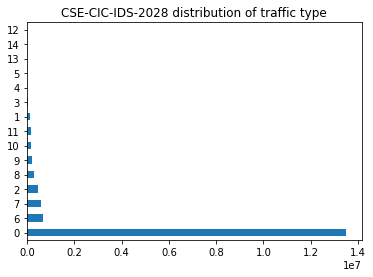

In [29]:
df['Label'].value_counts().plot(kind='barh')
plt.title('CSE-CIC-IDS-2028 distribution of traffic type')

In [30]:
# no se modelan días de la semana debido a que no hay información representativa sobre todos los días de la semana
df.insert(2, 'xhr', np.sin(2*math.pi*df['Timestamp'].dt.hour/24))
df.insert(3, 'yhr', np.cos(2*math.pi*df['Timestamp'].dt.hour/24))
df.pop('Timestamp')
df

,Dst Port,xhr,yhr,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Var,FIN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,Down/Up Ratio,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Active Mean,Active Std,Idle Min,Protocol_6,Protocol_17,Label
0,0,0.866025,-0.500000,112640768,3,0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,5.630000e+07,1.385929e+02,56300000.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,0,0.026633,0.000000,0.000000,0,0,0,0,0,0.0,-1,-1,0,0.0,0.000000,56300000.0,0,0,0
1,0,0.866025,-0.500000,112641773,3,0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,5.630000e+07,2.637508e+02,56300000.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,0,0.026633,0.000000,0.000000,0,0,0,0,0,0.0,-1,-1,0,0.0,0.000000,56300000.0,0,0,0
2,35605,0.866025,-0.500000,20784143,23,44,2416.0,240.0,64.0,105.043478,64.0,0.0,30.545455,3.149113e+05,1.145954e+06,9058214.0,20700000.0,4.823522e+05,1.396411e+06,9058214.0,41601.0,1,0,1.106613,2.116999,2900.003512,0,0,0,1,0,1.0,263,255,20,2624734.0,0.000000,9058214.0,1,0,0
3,0,0.866025,-0.500000,112640836,3,0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,5.630000e+07,8.202439e+01,56300000.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,0,0.026633,0.000000,0.000000,0,0,0,0,0,0.0,-1,-1,0,0.0,0.000000,56300000.0,0,0,0
4,23,0.866025,-0.500000,20,1,1,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,2.000000e+01,0.000000e+00,20.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,0,50000.000000,50000.000000,0.000000,0,0,1,0,0,1.0,58856,0,20,0.0,0.000000,0.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16232938,50111,0.707107,-0.707107,22,3,0,31.0,31.0,0.0,10.333333,0.0,0.0,0.000000,1.100000e+01,1.555635e+01,22.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,0,136363.636364,0.000000,240.250000,0,0,0,1,0,0.0,64,-1,20,0.0,0.000000,0.0,1,0,0
16232939,443,0.707107,-0.707107,54682783,5,1,123.0,46.0,0.0,24.600000,46.0,46.0,46.000000,1.093656e+07,2.436610e+07,54523813.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1,0,0.091436,0.018287,470.238095,0,0,0,1,0,0.0,256,180,20,158783.0,0.000000,54523813.0,1,0,0
16232940,443,0.707107,-0.707107,53682093,5,1,123.0,46.0,0.0,24.600000,46.0,46.0,46.000000,1.073642e+07,2.386193e+07,53421756.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1,0,0.093141,0.018628,470.238095,0,0,0,1,0,0.0,254,180,20,259719.0,0.000000,53421756.0,1,0,0
16232941,443,0.707107,-0.707107,54683364,5,1,123.0,46.0,0.0,24.600000,46.0,46.0,46.000000,1.093667e+07,2.436586e+07,54523593.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1,0,0.091435,0.018287,470.238095,0,0,0,1,0,0.0,254,180,20,158870.0,0.000000,54523593.0,1,0,0


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16232943 entries, 0 to 16232942
Data columns (total 41 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Dst Port           int64  
 1   xhr                float64
 2   yhr                float64
 3   Flow Duration      int64  
 4   Tot Fwd Pkts       int64  
 5   Tot Bwd Pkts       int64  
 6   TotLen Fwd Pkts    float64
 7   Fwd Pkt Len Max    float64
 8   Fwd Pkt Len Min    float64
 9   Fwd Pkt Len Mean   float64
 10  Bwd Pkt Len Max    float64
 11  Bwd Pkt Len Min    float64
 12  Bwd Pkt Len Mean   float64
 13  Flow IAT Mean      float64
 14  Flow IAT Std       float64
 15  Flow IAT Max       float64
 16  Bwd IAT Tot        float64
 17  Bwd IAT Mean       float64
 18  Bwd IAT Std        float64
 19  Bwd IAT Max        float64
 20  Bwd IAT Min        float64
 21  Fwd PSH Flags      int64  
 22  Fwd URG Flags      int64  
 23  Fwd Pkts/s         float64
 24  Bwd Pkts/s         float64
 25  Pkt Len Var     

Text(0.5, 1.0, 'Correlación respecto a target')

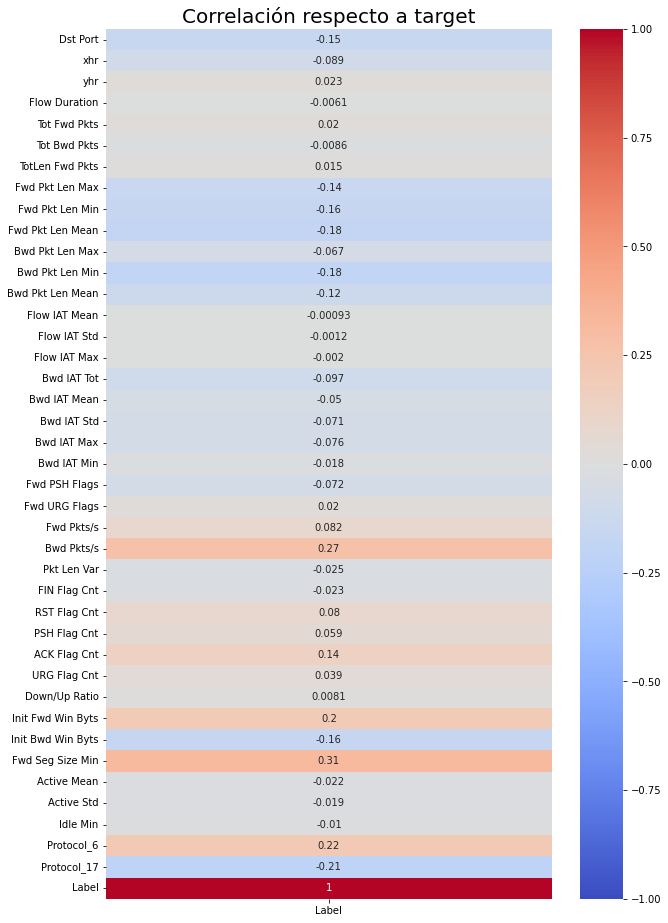

In [32]:
corr = df.corr()

kot = corr
plt.figure(figsize=(10,16))
sns.heatmap(kot[['Label']], cmap='coolwarm', annot=True, vmin=-1).set_title('Correlación respecto a target', fontsize=20)

In [33]:
df['Label'].value_counts()

0     13484708
6       686012
7       576191
2       461912
8       286191
9       193360
10      187589
11      161934
1       139890
3        41508
4        10990
5         1730
13         611
14         230
12          87
Name: Label, dtype: int64

In [ ]:
df.to_csv('preprocessed-multiclass.csv', index=False)